#### --------- 0) Imports (standard data-science stack) ----------

In [39]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

#### --------- 1) Basic settings — EDIT THESE FIRST -------------

In [41]:
FILE_PATH   = "MMM_Simulated_Data.csv"  # e.g., "MMM_Simulated_Data.csv" also works
WEEK_COL    = "week"                      # name of your week/time column
TARGET_COL  = "sales"                     # the column you want to predict

In [42]:
# Adstock decay for each spend column (0.0 = no memory, 0.2 = short memory, 0.6 = longer memory)
ADSTOCK = {
    "search_spend": 0.2,
    "social_spend": 0.3,
    "influencer_spend": 0.6,
    "display_spend": 0.4,
    "email_spend": 0.0,   # usually no carryover for email blasts
    "events_popups": 0.4
}

In [43]:
POSSIBLE_CONTROLS = [
    "price_index", "inventory_level", "promo_flag", "holiday_flag",
    "site_visits", "weather_index", "economic_index",
    "organic_search_visits", "affiliate_sales", "marketplace_sales", "events_popups", "bake_-season"
]

In [44]:
df = pd.read_csv(FILE_PATH)

In [45]:
if TARGET_COL not in df.columns:
    raise ValueError(f"Target column '{TARGET_COL}' not found in your file.")
if WEEK_COL not in df.columns:
    print(f"[WARN] Week column '{WEEK_COL}' not found. We'll create a simple index instead.")

In [46]:
# Isolating the spend columns
spend_cols = [c for c in df.columns if c.endswith("_spend") and not c.endswith("_adstock")]
if not spend_cols:
    raise ValueError("No RAW spend columns found (expected columns ending with '_spend').")
print("🧾 Spend columns detected:", spend_cols)

🧾 Spend columns detected: ['search_spend', 'social_spend', 'influencer_spend', 'display_spend', 'email_spend']


In [47]:
# Isolating the control columns
control_cols = [c for c in POSSIBLE_CONTROLS if c in df.columns]
print("🧭 Control columns used:", control_cols, "\n")


🧭 Control columns used: ['price_index', 'inventory_level', 'promo_flag', 'holiday_flag', 'site_visits', 'weather_index', 'economic_index', 'organic_search_visits', 'affiliate_sales', 'marketplace_sales', 'events_popups'] 



In [48]:
# adding in the carryover effect 
def adstock_transform(series: pd.Series, decay: float) -> pd.Series:
    """
    Turns a raw spend series into a 'memory-adjusted' series.
    Formula: Adstock[t] = Spend[t] + decay * Adstock[t-1]
    - If decay=0.6, 60% of last week's adstock carries into this week.
    """
    out = np.empty(series.shape[0], dtype=float)
    for i, v in enumerate(series.values):
        out[i] = v if i == 0 else v + decay * out[i-1]
    return pd.Series(out, index=series.index)

In [49]:
def build_features_from_raw(df_in: pd.DataFrame,
                            adstock_setup: dict,
                            controls: list[str] | None = None) -> pd.DataFrame:
    """
    Creates the modeling matrix (X) used by OLS:
      - For each spend column, if decay>0 use adstocked version, else use raw.
      - Appends any control columns passed in 'controls' that are present in df_in.
    Returns a new DataFrame X (features only).
    """
    parts = []
    # Add spends (adstocked or raw)
    for col in spend_cols:
        decay = adstock_setup.get(col, 0.0)
        if decay and decay > 0:
            parts.append(adstock_transform(df_in[col], decay).rename(f"{col}_adstock"))
        else:
            parts.append(df_in[col].rename(col))
    # Add controls (if they exist in the df)
    if controls:
        for c in controls:
            if c in df_in.columns:
                parts.append(df_in[c].rename(c))
    X = pd.concat(parts, axis=1)
    return X

In [50]:
X_train = build_features_from_raw(df, ADSTOCK, control_cols)       # build features from RAW
Xc_train = sm.add_constant(X_train, has_constant='add')            # add intercept (baseline sales)
y_train = df[TARGET_COL]                                           # your target (sales)

In [51]:
model = sm.OLS(y_train, Xc_train).fit()                            # fit the model
print("Model fit complete.")
print(f"   R-squared: {model.rsquared:.3f} | Adj R-squared: {model.rsquared_adj:.3f}\n")

Model fit complete.
   R-squared: 0.672 | Adj R-squared: 0.612



In [52]:
print("🍰 Coefficients (sorted):")
print(model.params.sort_values(ascending=False), "\n")

🍰 Coefficients (sorted):
const                       2174.657827
inventory_level              547.421250
promo_flag                   233.097109
holiday_flag                 120.238271
weather_index                 24.467822
social_spend_adstock          10.095807
search_spend_adstock           3.307482
influencer_spend_adstock       1.043740
events_popups                  0.360286
marketplace_sales              0.014998
affiliate_sales               -0.002914
site_visits                   -0.075649
email_spend                   -0.104813
organic_search_visits         -0.165491
economic_index                -0.826471
display_spend_adstock         -3.355935
price_index                -1146.627784
dtype: float64 



In [53]:
def budget_simulator(df_base: pd.DataFrame,
                     results,                      # fitted statsmodels OLS model
                     adstock_setup: dict,          # e.g., {'search_spend':0.2, ...}
                     multipliers: dict,            # e.g., {'search_spend':1.2, 'email_spend':0.9}
                     week_col: str = "week",
                     controls: list[str] | None = None,
                     show_plots: bool = True):
    """
    Runs a simple "what-if" budget test:
      1) Predict baseline sales from current spends
      2) Apply spend multipliers (e.g., +20% search)
      3) Rebuild features and predict scenario sales
      4) Compare baseline vs scenario and (optionally) plot

    Returns:
      out     -> per-week comparison DataFrame
      df_scen -> scenario DataFrame with adjusted RAW spends
    """

    # 1) Baseline prediction
    print("STEP 1️⃣  Predict baseline sales...")
    X_base = build_features_from_raw(df_base, adstock_setup, controls)
    Xc_base = sm.add_constant(X_base, has_constant='add')
    base_pred = results.predict(Xc_base)
    print(f"   Baseline total (pred): {base_pred.sum():,.0f}")

    # 2) Apply multipliers to RAW spends
    print("\nSTEP 2️⃣  Apply budget multipliers...")
    df_scen = df_base.copy()
    for col, m in multipliers.items():
        if col in df_scen.columns:
            before = df_scen[col].sum()
            df_scen[col] = df_scen[col] * m
            after = df_scen[col].sum()
            print(f"   {col}: x{m}  | total spend {before:,.0f} → {after:,.0f}")
        else:
            print(f"   [WARN] '{col}' not found; skipping.")
    print()

    # 3) Scenario prediction (same adstock rules)
    print("STEP 3️⃣  Predict scenario sales...")
    X_scen = build_features_from_raw(df_scen, adstock_setup, controls)
    Xc_scen = sm.add_constant(X_scen, has_constant='add')
    scen_pred = results.predict(Xc_scen)
    print(f"   Scenario total (pred): {scen_pred.sum():,.0f}")

    # 4) Compare and summarize
    print("\nSTEP 4️⃣  Compare baseline vs scenario...")
    weeks = df_base[week_col] if week_col in df_base.columns else np.arange(len(df_base))
    out = pd.DataFrame({
        week_col: weeks,
        "baseline_sales_pred": base_pred,
        "scenario_sales_pred": scen_pred
    })
    out["delta_abs"] = out["scenario_sales_pred"] - out["baseline_sales_pred"]
    out["delta_pct"] = np.where(
        out["baseline_sales_pred"] != 0,
        out["delta_abs"] / out["baseline_sales_pred"] * 100,
        np.nan
    )

    total_change = out["delta_abs"].sum()
    pct_change = (total_change / base_pred.sum()) * 100
    print(f"   Total Δ Sales: {total_change:,.0f}  ({pct_change:.2f}%)\n")

    # 5) Plots (one chart per figure, no custom colors)
    if show_plots:
        # A) Baseline vs Scenario line chart
        plt.figure(figsize=(10, 5))
        plt.plot(weeks, out["baseline_sales_pred"], label="Baseline (Pred)")
        plt.plot(weeks, out["scenario_sales_pred"], label="Scenario (Pred)")
        plt.xlabel("Week")
        plt.ylabel("Predicted Sales")
        plt.title("Baseline vs Scenario — Predicted Sales")
        plt.legend()
        plt.tight_layout()
        plt.show()

        # B) Weekly delta bar chart
        plt.figure(figsize=(10, 4))
        plt.bar(weeks, out["delta_abs"])
        plt.xlabel("Week")
        plt.ylabel("Δ Sales (Scenario - Baseline)")
        plt.title("Weekly Sales Change from Budget Adjustment")
        plt.tight_layout()
        plt.show()

    return out, df_scen


STEP 1️⃣  Predict baseline sales...
   Baseline total (pred): 153,893

STEP 2️⃣  Apply budget multipliers...
   search_spend: x1.2  | total spend 1,299 → 1,559
   email_spend: x0.9  | total spend 611 → 550

STEP 3️⃣  Predict scenario sales...
   Scenario total (pred): 154,970

STEP 4️⃣  Compare baseline vs scenario...
   Total Δ Sales: 1,078  (0.70%)



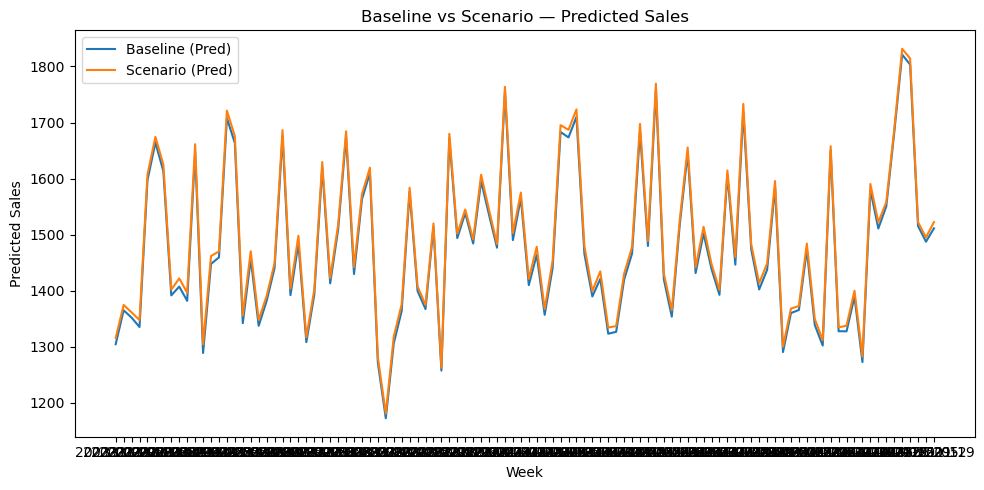

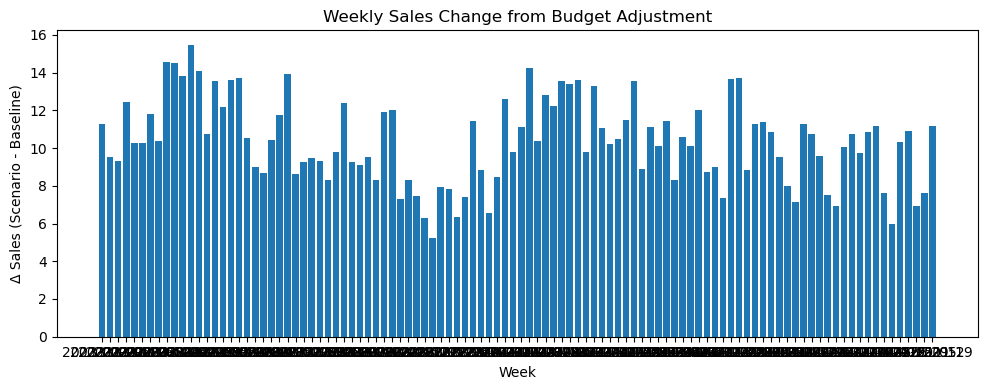

📌 First 5 rows of the comparison table:
         week  baseline_sales_pred  scenario_sales_pred  delta_abs  delta_pct
0  2023-01-29          1304.451016          1315.710847  11.259831   0.863185
1  2023-02-05          1365.026288          1374.543034   9.516746   0.697184
2  2023-02-12          1351.946996          1361.241288   9.294291   0.687475
3  2023-02-19          1335.149833          1347.615060  12.465227   0.933620
4  2023-02-26          1596.946582          1607.216894  10.270313   0.643122 



In [54]:
# Edit these multipliers. Keys must match your RAW spend column names.
multipliers_example = {
    "search_spend": 1.20,  # +20% search
    "email_spend":  0.90   # -10% email
    # You can add others: "social_spend": 1.10, "display_spend": 0.95, etc.
}

results_df, scenario_df = budget_simulator(
    df_base=df,
    results=model,
    adstock_setup=ADSTOCK,
    multipliers=multipliers_example,
    week_col=WEEK_COL,
    controls=control_cols,
    show_plots=True
)

print("📌 First 5 rows of the comparison table:")
print(results_df.head(), "\n")

In [56]:
# --------- 8) (Optional) Save outputs for Power BI -----------
#results_df.to_csv("mmm_budget_sim_results.csv", index=False)
#coefs = model.params.rename_axis("feature").reset_index(name="beta")
#coefs.to_csv("mmm_sales_coefficients.csv", index=False)
#features_export = sm.add_constant(build_features_from_raw(df, ADSTOCK, control_cols), has_constant='add')
#pd.concat([df[[WEEK_COL]] if WEEK_COL in df.columns else pd.Series(np.arange(len(df)), name=WEEK_COL),
          # features_export], axis=1).to_csv("mmm_sales_features_baseline.csv", index=False)

In [58]:
# --------- 8) (Optional) Save outputs for Power BI -----------
# Comparison table incl. RAW spends (baseline & scenario)
# results_df.to_csv("mmm_budget_sim_results.csv", index=False)

# Coefficients (for DAX beta lookup)
coefs = model.params.rename_axis("feature").reset_index(name="beta")
coefs.to_csv("mmm_sales_coefficients.csv", index=False)

# Baseline features (X with const) for DAX “live” calc
features_export = sm.add_constant(build_features_from_raw(df, ADSTOCK, control_cols), has_constant='add')
pd.concat(
     [df[[WEEK_COL]] if WEEK_COL in df.columns else pd.Series(np.arange(len(df)), name=WEEK_COL),
      features_export],
     axis=1
 ).to_csv("mmm_sales_features_baseline.csv", index=False)